In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

2023-05-25 20:58:08.343489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pathlib

data_dir = pathlib.Path('/Users/dilnazahmetzan/Downloads/capstone')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

777


In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg",".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 832 files belonging to 5 classes.
Using 666 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 832 files belonging to 5 classes.
Using 166 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['acne', 'blackhead', 'carcinoma', 'norm', 'wrinkles']


In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-05-25 21:05:17.166356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [666]
	 [[{{node Placeholder/_4}}]]
2023-05-25 21:05:17.167260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [666]
	 [[{{node Placeholder/_4}}]]


(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-05-25 21:05:27.858471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [666]
	 [[{{node Placeholder/_0}}]]
2023-05-25 21:05:27.859336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [666]
	 [[{{node Placeholder/_0}}]]


0.4885855 0.9203981


In [14]:
num_classes=len(class_names)

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
    ]
)
inputs = keras.Input(shape=image_batch.shape)

In [16]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2,input_shape=(224,224,3)), #change to 0.2 and try
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [18]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",

    )
]
my_callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='mod.{val_accuracy:.2f}.h5')
]

In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
epochs = 27
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/27


2023-05-25 21:06:03.926519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [666]
	 [[{{node Placeholder/_0}}]]
2023-05-25 21:06:03.927561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [666]
	 [[{{node Placeholder/_4}}]]
/Users/dilnazahmetzan/anaconda3/envs/capstone/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits 

21/21 [==============================] - ETA: 0s - loss: 2.1187 - accuracy: 0.2432

2023-05-25 21:06:31.115326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [166]
	 [[{{node Placeholder/_0}}]]
2023-05-25 21:06:31.116148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [166]
	 [[{{node Placeholder/_0}}]]


21/21 [==============================] - 30s 1s/step - loss: 2.1187 - accuracy: 0.2432 - val_loss: 1.5214 - val_accuracy: 0.2831
Epoch 2/27
21/21 [==============================] - 23s 1s/step - loss: 1.4516 - accuracy: 0.3874 - val_loss: 1.2140 - val_accuracy: 0.5120
Epoch 3/27
21/21 [==============================] - 23s 1s/step - loss: 1.2304 - accuracy: 0.4895 - val_loss: 1.0570 - val_accuracy: 0.6084
Epoch 4/27
21/21 [==============================] - 22s 1s/step - loss: 1.0467 - accuracy: 0.6066 - val_loss: 1.0363 - val_accuracy: 0.5843
Epoch 5/27
21/21 [==============================] - 23s 1s/step - loss: 0.9763 - accuracy: 0.6186 - val_loss: 1.0607 - val_accuracy: 0.6024
Epoch 6/27
21/21 [==============================] - 23s 1s/step - loss: 0.7976 - accuracy: 0.7042 - val_loss: 1.0002 - val_accuracy: 0.6024
Epoch 7/27
21/21 [==============================] - 24s 1s/step - loss: 0.6747 - accuracy: 0.7462 - val_loss: 0.9496 - val_accuracy: 0.6506
Epoch 8/27
11/21 [=============


KeyboardInterrupt



In [55]:
model.save("model_test.h5")

In [60]:
!tensorflowjs_converter \
    --input_format=keras \
    model_test.h5 \
    model_test2

In [59]:
!tensorflowjs_converter \
    --input_format keras \
    --output_format=tfjs_graph_model\
    model_test.h5 \
    model_test

In [54]:
tf.keras.utils.load_img(
    '/Users/dilnazahmetzan/Downloads/blk.jpg',
    grayscale=False,
    color_mode="rgb",
    target_size=None,
    interpolation="nearest",
    keep_aspect_ratio=False,
)

AttributeError: 'Sequential' object has no attribute 'load_model'

In [26]:

model = keras.models.load_model('model.0.73.h5')

In [32]:
image = tf.keras.utils.load_img('/Users/dilnazahmetzan/Downloads/capstone/acne/istockphoto-174763312-612x612.jpg',target_size =(224,224))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

1/1 [==============================] - 0s 54ms/step


In [29]:
print(predictions)

[[ 3.992947    0.23258507  2.9504135  -0.41028017]]


In [33]:
print(predictions)

[[3.3456638  1.8703495  0.9135755  0.54006696]]


In [ ]:
import tensorflowjs

In [ ]:
!tensorflowjs_converter \ --input_format keras \--output_format=tfjs_graph_model G:/capstone/test.h5 G:/capstone/Test/

In [65]:
!tensorflowjs_converter \
    --input_format=keras \
    model.0.72.h5 \
    my_tfjs_model_new

In [30]:
print(train_ds.DTypes)

AttributeError: '_PrefetchDataset' object has no attribute 'DTypes'

In [45]:
model.save('/Users/dilnazahmetzan/DataspellProjects/capstone/model75.h5')

In [43]:
model.save('/Users/dilnazahmetzan/DataspellProjects/capstone/model75')

INFO:tensorflow:Assets written to: /Users/dilnazimanbaeva/DataspellProjects/capstone/model75/assets


INFO:tensorflow:Assets written to: /Users/dilnazimanbaeva/DataspellProjects/capstone/model75/assets


In [ ]:
model.predict()

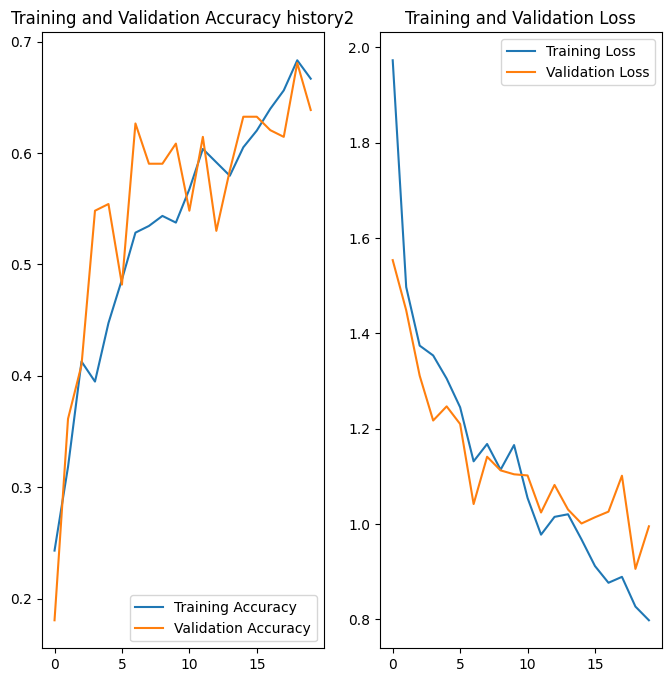

In [39]:
acc = history.history['accuracy']#basic code from tf
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy history2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import load_model
json_file = open('/Users/dilnazahmetzan/PycharmProjects/pythonProject5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model79.h5")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dilnazahmetzan/PycharmProjects/pythonProject5/model.json'

In [ ]:
model.save('model_78.h5')

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1)
    ]
)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
from keras.optimizers import SGD
epochs = 10
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9,  nesterov=False, decay = decay)
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

In [ ]:
num_classes = len(class_names)
epochs = 10
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1)
    ]
)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = model.fit( #4
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy'] #more dropout
val_acc = history.history['val_accuracy']
acc2 = history2.history['val_accuracy']
acc3 = history3.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, acc2, label='2')
plt.plot(epochs_range, acc3, label='3')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "relu"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(224,224) + (3,), num_classes=6)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history_32=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:

acc = history.history['accuracy']  #basic code from tf
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy history2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf

image_dir = '/Users/dilnazimanbaeva/Downloads/capstone/'

files = tf.data.Dataset.list_files(image_dir + '*.jpg')

def load(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_image(image)
    return image

ds = files.map(load)


In [ ]:
RESIZE_TO = 224
CROP_TO = 224
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 6  # number of classes
SCHEDULE_LENGTH = (
    100  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase


In [ ]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 10 + 1  # To ensure at least there are 50 epochs of training

In [ ]:
pipeline_train = (
     train_ds.shuffle(100)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow((image_batch[n]* 255).astype(np.uint8))
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [ ]:
import tensorflow_hub as hub

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.legacy.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
accuracy = model.evaluate(val_ds)[2] * 100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D,MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
#from keras.preprocessing.image import
from keras.utils import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import pandas as pd
import tensorflow as tf
import keras
import pickle

In [ ]:
base_dir='/Users/dilnazimanbaeva/Downloads/capstone'
import os
for dirname, _, filenames in os.walk('/Users/dilnazimanbaeva/Downloads'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
train_list_mod=class_names

In [ ]:
def data_dictionary():
    path_train="/content/drive/MyDrive/acne2/train/"
    path_test="/content/drive/MyDrive/acne2/testing/"
    list_train=train_list_mod#os.listdir(path_train)
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        path_disease_test=path_test+i
        image_list_train=os.listdir(path_disease_train)
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k)
        for m in image_list_test :
            img_path_test=path_disease_test+"/"+m
            test_dictionary["image_path"].append(img_path_test)
            test_dictionary['target'].append(k)
        k+=1
    test_df=pd.DataFrame(test_dictionary)
    train_df=pd.DataFrame(train_dictionary)

    return  train_df,test_df

In [ ]:

from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import load_model
json_file = open('../model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model (2).h5")

In [34]:
import cv2
test=cv2.imread('/Users/dilnazimanbaeva/DataspellProjects/capstone/extracted/photo1682589067_chin.jpg')
test=cv2.resize(test,(224,224),3)


model.predict(test)

ValueError: in user code:

    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/dilnazimanbaeva/DataspellProjects/capstone/venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


In [56]:
y_pred2=model.predict(val_ds.take(2))
y_pred2__cl=y_pred2.argmax(axis=1)[0]
print(y_pred2__cl)

In [53]:
plt.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [79]:
import cv2
img_rgb=cv2.imread('/Users/dilnazahmetzan/Downloads/acn.jpg')
img_rgb = cv2.resize(img_rgb,(224,224),3)  # resize
img_rgb = np.array(img_rgb).astype(np.float32)/255.0  # scaling
img_rgb = np.expand_dims(img_rgb, axis=0)  # expand dimension
y_pred = new_model.predict(img_rgb) # prediction
y_pred_class = y_pred.argmax(axis=1)
print(y_pred_class)
print(y_pred)

1/1 [==============================] - 1s 560ms/step
[3]
[[2.1347077 3.9516485 3.7709062 5.9239917]]


In [80]:
import cv2
img_rgb=cv2.imread('/Users/dilnazahmetzan/Downloads/blk.jpg')
img_rgb = cv2.resize(img_rgb,(224,224),3)  # resize
img_rgb = np.array(img_rgb).astype(np.float32)/255.0  # scaling
img_rgb = np.expand_dims(img_rgb, axis=0)  # expand dimension
y_pred = new_model.predict(img_rgb) # prediction
y_pred_class = y_pred.argmax(axis=1)
print(y_pred_class)
print(y_pred)

1/1 [==============================] - 0s 151ms/step
[3]
[[2.11193   3.961391  3.7858098 5.9590917]]


In [81]:
import cv2
img_rgb=cv2.imread('/Users/dilnazahmetzan/Downloads/wrn.jpeg')
img_rgb = cv2.resize(img_rgb,(224,224),3)  # resize
img_rgb = np.array(img_rgb).astype(np.float32)/255.0  # scaling
img_rgb = np.expand_dims(img_rgb, axis=0)  # expand dimension
y_pred = new_model.predict(img_rgb) # prediction
y_pred_class = y_pred.argmax(axis=1)
print(y_pred_class)
print(y_pred)

1/1 [==============================] - 0s 85ms/step
[3]
[[2.11094   3.9356441 3.7739816 5.9771204]]


In [78]:
new_model = tf.keras.models.load_model('model.0.73.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [83]:
new_model.save('new_model.h5')

In [84]:
!tensorflowjs_converter \
    --input_format=keras \
    new_model.h5 \
    my

In [1]:
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.models import load_model
model = load_model('/Users/dilnazahmetzan/Downloads/skin-assistant/model/mode.0.80.h5')

2023-05-27 19:46:09.184679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Unknown layer: Rescaling. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.